In [1]:
import paths
import yaml
import os
import copy
import h5py
import GPy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker, colors
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
from cklemap.sdfs.darcy import DarcyExp
from cklemap.sdfs.dasa import DASAExpLM, DASAExpLMAMPS
import cklemap.ckli.mapest as mapest

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
amps = True
seed = 0
num_trials = 10
#Nuobs = 50
NYobs = 25
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
beta_ckli = 1e1
Ygamma_ckli = 1e-4
ugamma_ckli = 1e-4
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
res_fac = 1
resolution = '4x'
resolution_ref = '1x'
resolution_iYobs = '4x'
lsq_method = 'trf'
run_MAP = True
run_PICKLE = False
data_path = '../data/'
results_path = '../results/'
figures_path = '../figures/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
geom_ref_filename = data_path + f'geom/geom_{resolution_ref}.mat'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'yref/conduct_log_RF1_{resolution_ref}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution}.npy'
yobs_fine_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
ref = f'Yref=RF1'


In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
if resolution_ref != resolution:
    geom_ref = GeomMRST(geom_ref_filename)
else:
    geom_ref = geom
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]
patches_ref = [mpatches.Polygon(v, closed=True) for v in geom_ref.nodes.coords.T[geom_ref.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref_orig = f.get('conduct_log')[:].ravel() - Yfac

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref + Yfac, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
geom_fine = GeomMRST(geom_fine_filename)

if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
elif os.path.exists(yobs_fine_filename):
    print(f"iYobs set read from file {yobs_fine_filename} and randomly selected nearby cell")
    iYobs_fine = np.load(yobs_fine_filename)
    geom_fine = GeomMRST(geom_ref_filename)
    iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])
    np.save(yobs_filename, iYobs)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs_ref = np.array([geom_ref.cellsContain(geom_fine.cells.centroids.T[iYobs[t]]) for t in range(num_trials)])
iYlearn = iYobs_ref
Ylearn = np.array([Yref_orig[iYlearn[t]] for t in range(num_trials)])

iYobs set read from file ../data/yobs/yobs_25_4x.npy
iYobs.shape=(10, 25)
[[ 926 1306 1445 1448 1682 1785 1834 1948 2233 2607 2696 3034 3045 3355
  3415 3431 3536 3590 3602 4124 4457 4629 5355 5776 5862]
 [  90  584  733  995 1210 1245 1746 1819 1980 2135 2400 2461 2692 2783
  3224 3367 3733 4020 4039 4152 4345 4900 4970 5295 5456]
 [ 360  386  464  611  633  638 1079 1313 1358 1571 1604 2120 2164 2285
  2603 3237 3766 3926 4143 4397 4635 4660 4778 5219 5777]
 [ 430  450  659  681 1163 1328 1348 1620 2188 2230 2278 2369 2482 2705
  2792 2825 3529 3868 3931 4327 4523 5046 5151 5293 5581]
 [ 173  220  800 1096 1293 1355 1507 1516 2254 2291 2607 2886 3189 4107
  4271 4296 4573 4939 4964 5502 5640 5741 5815 5829 5868]
 [  93  819  887  908 1002 2196 2300 2310 2382 3057 3268 3359 3420 3481
  4065 4593 5026 5139 5154 5161 5167 5259 5397 5575 5658]
 [ 208  403  475  873 1945 1997 2463 2595 3137 3290 3299 3398 3412 3893
  3902 4217 4430 4458 4516 4625 5238 5473 5583 5685 5720]
 [ 346  449  568

In [9]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yref = np.zeros((num_trials, Nc))
CYref = np.zeros((num_trials, Nc, Nc))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
Psiu = np.zeros((num_trials, Nc, Nuxi))
Lambdau = np.zeros((num_trials, Nuxi))

uxi = np.zeros((num_trials, Nuxi))
Yxi = np.zeros((num_trials, NYxi))
uest = np.zeros((num_trials, Nc))
Yest = np.zeros((num_trials, Nc))
Yest_MAPH1 = np.zeros((num_trials, Nc))

In [10]:
for t in range(num_trials):    
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom_ref.cells.centroids[:, iYlearn[t]].T, Ylearn[t, :, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom_ref.cells.centroids.T, Yref_orig[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Yref[t], CYref[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))

Yobs = np.array([Yref[t, iYobs[t]] for t in range(num_trials)])

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   9.993800e+01           nan 
    00s01  0005   4.237642e+01   1.349934e+01 
    00s03  0010   4.067659e+01   1.529230e-03 
    00s05  0016   4.067551e+01   2.902244e-11 
Runtime:     00s05
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007   3.608421e+01   3.052412e+00 
    00s03  0012   3.511862e+01   7.611427e-05 
    00s05  0016   3.511860e+01   1.068422e-10 
Runtime:     00s05
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   4.326245e+01   3.410234e+01 
    00s02  0011   4.041663e+01   1.751980e-06 
    00s03  0013   4.041663e+01   1.178537e-10 
Runtime:     00s03
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00 

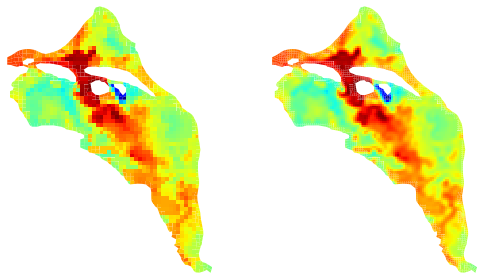

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_patch(patches_ref, Yref_orig + Yfac, fig, ax[0], None, 'Yref', 0, 12)
plot_patch(patches, Yref[0] + Yfac, fig, ax[1], None, 'Yref_4x', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_{resolution_ref=}_NY={NYobs}_{resolution}.pdf', dpi=300)

In [12]:
# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
Nuobs = iuobs.size

prob = DarcyExp(TPFA(geom, bc), iuobs, amps, None)

uref = np.array([prob.solve(Yref[t]) for t in range(num_trials)])
uobs = uref[:, iuobs]


In [13]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_gamma={gamma_map}_{lsq_method=}_h1reg_{amps=}_{ref}'
print(exp)

NY=25_Nu=408_NYlearn=25_gamma=1e-06_lsq_method='trf'_h1reg_amps=True_Yref=RF1


In [14]:
""" Yest_MAPH1 = np.loadtxt(results_path + f'YMAP/YMAP_{exp}.txt')

fig, ax = plt.subplots(figsize=(4, 4))
plot_patch(patches, np.abs(Yest_MAPH1[0] - Yref[0]), fig, ax, None, '|Yest_MAP - Yref|', None, None, True)
fig.tight_layout()
#fig.savefig(figures_path + f'Ydiff_MAP/Ydiff_MAP_{exp}.pdf', dpi=300) """

" Yest_MAPH1 = np.loadtxt(results_path + f'YMAP/YMAP_{exp}.txt')\n\nfig, ax = plt.subplots(figsize=(4, 4))\nplot_patch(patches, np.abs(Yest_MAPH1[0] - Yref[0]), fig, ax, None, '|Yest_MAP - Yref|', None, None, True)\nfig.tight_layout()\n#fig.savefig(figures_path + f'Ydiff_MAP/Ydiff_MAP_{exp}.pdf', dpi=300) "

In [15]:
""" rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref[t]) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref[t]) for t in range(num_trials)])
print(f"MAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors) """

' rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref[t]) for t in range(num_trials)])\nabs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref[t]) for t in range(num_trials)])\nprint(f"MAP\trelative L2 error: {rel_errors[:, 2]}")\nprint(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")\nnp.savetxt(results_path + f\'rel_errors/rel_errors_{exp}.txt\', rel_errors)\nnp.savetxt(results_path + f\'abs_errors/abs_errors_{exp}.txt\', abs_errors) '

In [16]:
if run_PICKLE:
    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:,iYlearn].T, Ylearn[:,None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs].T, Yobs[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred, CYpred = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[0] = perf_counter() - ts

    print(f"GPR: {timings[0] : g} s")

In [17]:
if run_PICKLE:
    # Compute GP model for u
    ts = perf_counter()
    umean, Cu = ckliest.smc_gp(Ypred, CYpred, Nens, prob, rs)
    upred, Cupred = ckliest.gpr(umean, Cu, uobs, iuobs)
    timings[1] = perf_counter() - ts

    print(f"Monte Carlo: {timings[1] : g} s")

In [18]:
if run_PICKLE:
    # PICKLE models
    Ym = Ypred
    CYm = CYpred
    um = umean #or change to upred
    Cum = Cu #or change to Cupred

    rel_errors[0] = rl2e(Ym, Yref)
    abs_errors[0] = infe(Ym, Yref)

    print(f"Monte Carlo: {timings[1] : g} s")
    print(f"GPR\trelative L2 error: {rel_errors[0] : g}")
    print(f"GPR\tabsolute infinity error: {abs_errors[0] : g}")

In [19]:
if run_PICKLE:
    ts = perf_counter()
    PsiY, LambdaY = ckliest.KL_via_eigh(CYm, NYxi)
    Psiu, Lambdau = ckliest.KL_via_eigh(Cum, Nuxi)
    timings[2] = perf_counter() - ts

    print(f"eigendecomposition: {timings[2] : g} s")

In [20]:
# PICKLE estimate
Lreg = mapest.compute_Lreg(geom)
ssv = None

if run_PICKLE:
    res = ckliest.LeastSqRes(NYxi, Ym, PsiY, Nuxi, um, Psiu, prob, ugamma_ckli, Ygamma_ckli, res_fac, Lreg, iuobs, uobs, iYobs, Yobs, beta_ckli, ssv=ssv)
    x0 = np.zeros(Nuxi + NYxi)
        
    ts = perf_counter()
    sol = spo.least_squares(res.val, x0, jac=res.jac, method=lsq_method, verbose=2)
    ckli_status = sol.status
    timings[3] = perf_counter() - ts
    nfevs[0] = sol.nfev
    print(f'CKLI optimality: {sol.optimality : g}')

    uxi = sol.x[:Nuxi]
    Yxi = sol.x[Nuxi:]
    uest = um + Psiu @ uxi
    Yest = Ym + PsiY @ Yxi

    rel_errors[1] = rl2e(Yest, Yref)
    abs_errors[1] = infe(Yest, Yref)

    print(f"PICKLE: {timings[3] : g} s")
    print(f"PICKLE\trelative L2 error: {rel_errors[1] : g}")
    print(f"PICKLE\tabsolute infinity error: {abs_errors[1] : g}")

In [21]:
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    # MAP H1 estimate
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs[t], iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpLMAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    else:
        dasa = DASAExpLM(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(Nc), jac=dasa.grad, method=lsq_method, verbose=2)
    timings[t, 0] = perf_counter() - ts
    timings[t, 1] = dasa.jac_time
    timings[t, 2] = dasa.dhdp_time
    timings[t, 3] = dasa.grad_time
    nfevs[t, 1] = sol.nfev

    Yest_MAPH1[t] = sol.x
    print(f'MAP status: {sol.status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref[t]) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref[t]) for t in range(num_trials)])

print(f"MAP: {timings[:, 0]} s")
print(f"\tJacobian time: {timings[:, 1]} s")
print(f"\tdLdp time: {timings[:, 2]} s")
print(f"\tgrad time: {timings[:, 3]} s")
print(f"MAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")


adj size = (5900, 408), nnz = 2407200
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5312e+02                                    1.31e+01    
adj size = (5900, 408), nnz = 2407200
       1              2         5.0695e+02      4.62e+01       1.00e+00       9.35e+00    
adj size = (5900, 408), nnz = 2407200
       2              3         4.3587e+02      7.11e+01       2.00e+00       5.22e+00    
adj size = (5900, 408), nnz = 2407200
       3              4         3.3559e+02      1.00e+02       4.00e+00       3.45e+00    
adj size = (5900, 408), nnz = 2407200
       4              5         2.0355e+02      1.32e+02       8.00e+00       2.01e+00    
adj size = (5900, 408), nnz = 2407200
       5              6         7.3255e+01      1.30e+02       1.60e+01       1.33e+00    
adj size = (5900, 408), nnz = 2407200
       6              7         2.0484e+01      5.28e+01       3.20e+01       4.13e+00    
adj si

In [ ]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YPICKLE/YPICKLE_{exp}.txt', Yest)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest_MAPH1)

In [ ]:
t = 9

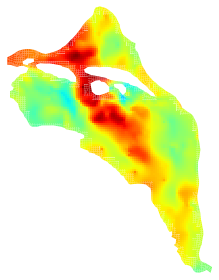

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_patch(patches, Yest_MAPH1[t] + Yfac, fig, ax, None, 'Yest_MAP', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'YMAP/YMAP_{exp}_{t=}.pdf', dpi=300)

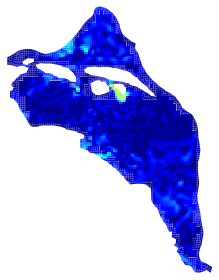

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
p = plot_patch(patches, np.abs(Yest_MAPH1[t] - Yref[t]), fig, ax, None, '|Yest_MAP - Yref|', 0, 7)
fig.tight_layout()
fig.savefig(figures_path + f'Ydiff_MAP/Ydiff_MAP_{exp}_{t=}.pdf', dpi=300)